In [23]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.cm as cm
import os
import glob

In [24]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

### Set up CPU mode and load caffemodel

In [26]:
caffe.set_mode_cpu()

# Test the partially trained new model using Alexnet
model_def = caffe_root + 'models/kaggle_cats_dogs_alexnet/deploy.prototxt'
# Replace it once fully trained new model using Alexnet
model_weights = caffe_root + 'models/kaggle_cats_dogs_alexnet/caffe_alexnet_train_iter_5000.caffemodel'

# TODO: Uncomment when transfer learning is done for this model
# model_def = caffe_root + 'models/kaggle_cats_dogs_caffenet/deploy.prototxt'
# model_weights = caffe_root + 'models/kaggle_cats_dogs_caffenet/caffe_caffenet_train_iter_1000.caffemodel'

# Use this existing trained model until the training is in progress for the rest of the two
# model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
# model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)


### Set up input preprocessing

* (We'll use Caffe's caffe.io.Transformer to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

* Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (outermost) dimension.

* As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the innermost dimension, we are arranging for the needed transformations here.

In [27]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


### Add labels (optional)

* If you have many classes then you can create a mapping for the class id and the name. 
  for instance, in [**ILSVRC12**](https://github.com/onkarganjewar/caffe/blob/master/data/ilsvrc12/get_ilsvrc_aux.sh#L15) there are thousands of classes mapped with labels such as
  207 --> dog
* In our case, we only have two classes dog (1) or cat (0).   

In [28]:
# load ImageNet labels
# labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
# if not os.path.exists(labels_file):
#     !../data/ilsvrc12/get_ilsvrc_aux.sh
    
# labels = np.loadtxt(labels_file, str, delimiter='\t')

### Run net to classify single input image for test (optional)

Issa dog!!


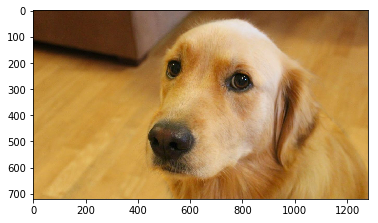

In [29]:
filename = caffe_root + 'examples/doggo.jpg'
# transform the image and copy it into the net
image = caffe.io.load_image(filename)
plt.imshow(image)

net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
output = net.forward()

# the output probability vector for the first image in the batch
output_prob = output['prob'][0]  

output_class = output_prob.argmax()

print 'Issa {}!!'.format('dog' if output_class else 'cat') 


### Run net on a set of input images

* We will run our trained net on the list of sample images inside the specified directory.
* Also, image files will be sorted by name for readability purposes, thanks to [Jeff Atwood](https://blog.codinghorror.com/sorting-for-humans-natural-sort-order/)

In [30]:
import re 
def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [31]:
# caffe_root = '/Users/ganon01/Documents/Work/Hackathon/image-classification/caffe/'
img_dir_path = caffe_root + 'data/kaggle-cats-dogs/demo-test-images'
img_list = os.listdir(img_dir_path)
sorted_img_list = sorted_nicely(img_list)
print img_dir_path

for filename in sorted_img_list:
    # transform the image and copy it into the net
    image = caffe.io.load_image(img_dir_path + '/' + filename)
    net.blobs['data'].data[...] = transformer.preprocess('data', image)

    # perform classification
    output = net.forward()
    
    # the output probability vector for the first image in the batch
    output_prob = output['prob'][0]  
    
    output_class = output_prob.argmax()
#     print(output_class) 
    # 1 for dog, 0 for cat
    print 'predicted class for {}: {}'.format(os.path.basename(filename), ('dog' if output_class else 'cat'))

../data/kaggle-cats-dogs/demo-test-images
predicted class for cat-5.jpg: cat
predicted class for cat-6.jpg: cat
predicted class for cat-7.jpg: cat
predicted class for cat-8.jpg: dog
predicted class for cat-9.jpg: cat
predicted class for cat-10.jpg: cat
predicted class for cat-11.jpg: cat
predicted class for cat-13.jpg: cat
predicted class for cat-14.jpg: cat
predicted class for cat-15.jpg: cat
predicted class for cat-16.jpg: cat
predicted class for cat-19.jpg: cat
predicted class for cat-20.jpg: cat
predicted class for cat-22.jpg: cat
predicted class for cat-25.jpg: cat
predicted class for cat-28.jpg: cat
predicted class for cat-29.jpg: dog
predicted class for dog-1.jpg: dog
predicted class for dog-2.jpg: dog
predicted class for dog-3.jpg: dog
predicted class for dog-4.jpg: dog
predicted class for dog-12.jpg: dog
predicted class for dog-17.jpg: dog
predicted class for dog-18.jpg: dog
predicted class for dog-21.jpg: dog
predicted class for dog-23.jpg: dog
predicted class for dog-24.jpg:

### Run the net on set of test images by Kaggle (optional)

* We can run our trained network on the 12.5k test images provided by [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data)
* Also, the output is structured in the way specified by the [Kaggle Dogs vs. Cats competition](https://www.kaggle.com/c/dogs-vs-cats#evaluation)

> Your submission should have a header. For each image in the test set, predict a label for its id **(1 = dog, 0 = cat)**:
```
id,label
1,0
2,0
3,0
etc...
```

In [32]:
import csv
result_dict = {}

def test_kaggle_dataset( img_dir_path ):
    img_list = os.listdir(img_dir_path)
    sorted_img_list = sorted_nicely(img_list)
    print img_dir_path
    
    for filename in sorted_img_list:
#             print filename
        # transform the image and copy it into the net
        image = caffe.io.load_image(img_dir_path + '/' + filename) # since we are sorting only the filenames we have to provide full path to load the image here
        net.blobs['data'].data[...] = transformer.preprocess('data', image)
        # perform classification
        output = net.forward()

        # the output probability vector for the first image in the batch
        output_prob = output['prob'][0]  

        output_class = output_prob.argmax()
        result_dict[os.path.splitext(os.path.basename(filename))[0]] = str(output_class)
    #     print(output_class) 
        # 1 for dog, 0 for cat
        ## Write output into a csv file for submission
        op_file = caffe_root + 'data/kaggle-cats-dogs/kaggle-test-submission-1.csv'

        with open(op_file, 'wb') as csv_file:
            fwriter = csv.writer(csv_file)
            fwriter.writerow(["id", "label"])

            for key, value in result_dict.items():
                fwriter.writerow([key, value])

In [33]:
# test_kaggle_dataset(caffe_root + 'data/kaggle-cats-dogs/test')